# Test on Fashion Dataset


This notebook shows how to load a pretrained model and perform test on Fashion Dataset. The model is trained on a very small dataset, but you can still see some results.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from pycocotools.coco import COCO

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class TestConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # background + 13 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset
Raw dataset related.

In [4]:
import io
import lmdb
import sqlite3
import pandas as pd
import json
from PIL import Image
from IPython.display import display

In [5]:
class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
        
    def __len__(self):
        return self.env.stat()['entries']

photo_data = PhotoData(r'..'+os.path.sep+'..'+os.path.sep+'..'+os.path.sep+'photos.lmdb')

In [6]:
json_file = r'..' + os.path.sep + '..' + os.path.sep + '..' + os.path.sep + 'modanet2018_instances_train.json'
d = json.load(open(json_file))
coco=COCO(json_file)

loading annotations into memory...
Done (t=4.03s)
creating index...
index created!


# Fashion Dataset Class
Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [7]:
from pycocotools import mask as maskUtils

class FashionDataset(utils.Dataset):

    def load_fashion(self, count=5, start=0, class_ids=None):
        json_file = r'..' + os.path.sep + '..' + os.path.sep + '..' + os.path.sep + 'modanet2018_instances_train.json'
        d = json.load(open(json_file))
        coco=COCO(json_file)
        
        if not class_ids:
            class_ids = sorted(coco.getCatIds())
        
        if class_ids:
            all_ids = []
            for id in class_ids:
                all_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            all_ids = list(set(all_ids))
        else:
            # All images
            all_ids = list(coco.imgs.keys())
        random.seed(3)
        random.shuffle(all_ids)
        
        all_class_ids = sorted(coco.getCatIds())
        for i in all_class_ids:
            print('{}:{}'.format(i, coco.loadCats(i)[0]['name']), end='|')
            self.add_class("fashion", i, coco.loadCats(i)[0]['name'])
            
              
        image_ids = []
        for c in range(count):
            image_ids.append(all_ids[c+start])
            
        
        # Add images
        for i in image_ids:
            self.add_image(
                "fashion", image_id=i,
                path=None,
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
            

    def load_image(self, image_id):
        imgId = self.image_info[image_id]['id']
        image = photo_data[imgId]
        out = np.array(image.getdata()).astype(np.int32).reshape((image.size[1], image.size[0], 3))
        return out
            

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        pass
    

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id']
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(FashionDataset, self).load_mask(image_id)
        

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

## Detection

In [8]:
subset = sorted(coco.getCatIds(catNms=['bag', 'belt', 'outer', 'dress', 'pants', 'top', 'shorts', 'skirt', 'scarf/tie']))
test_config = TestConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=test_config,
                          model_dir=MODEL_DIR)
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  C:\Training\DeepLearningGit\virtualFitting\mask_rcnn\logs\fashion20190527T1740\mask_rcnn_fashion_0200.h5
Re-starting from epoch 200


In [14]:
val_count = 5
dataset_test = FashionDataset()
dataset_test.load_fashion(val_count, start=39005, class_ids=subset)
dataset_test.prepare()

loading annotations into memory...
Done (t=3.73s)
creating index...
index created!
1:bag|2:belt|3:boots|4:footwear|5:outer|6:dress|7:sunglasses|8:pants|9:top|10:shorts|11:skirt|12:headwear|13:scarf/tie|

=============== Load Images ===============
Load 5 images
=============== Perform Testing ===============
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  int32
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  int32
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max

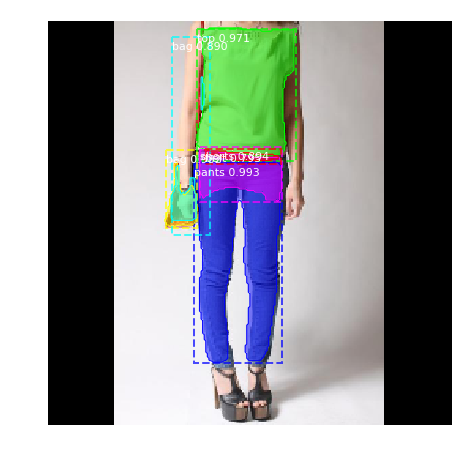

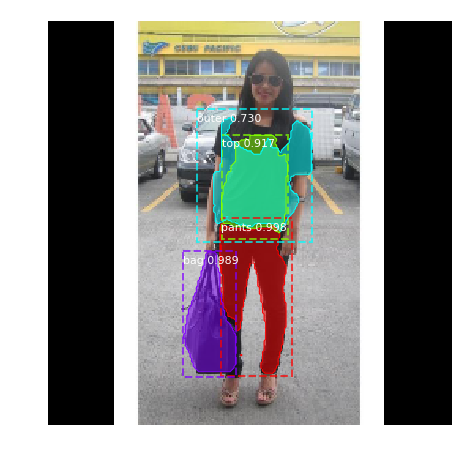

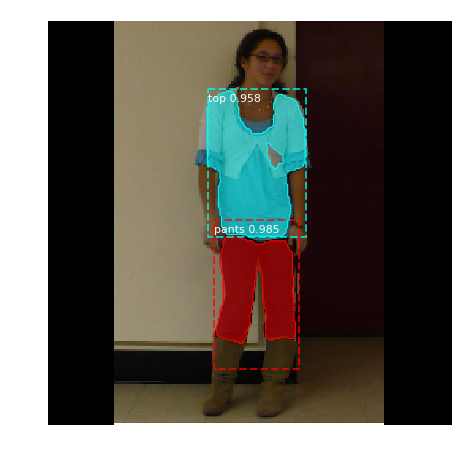

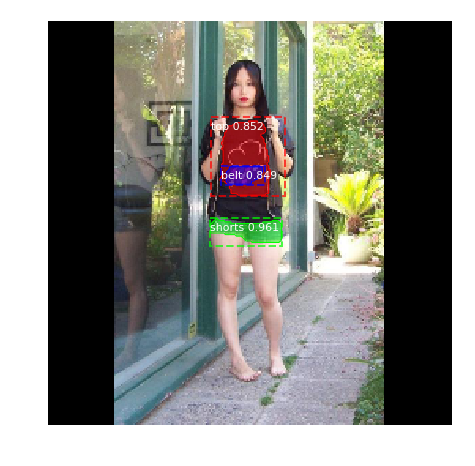

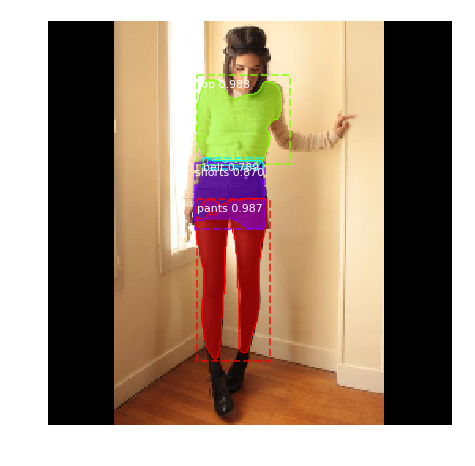

In [15]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# image_ids = dataset_val.image_ids
print('=============== Load Images ===============')
print('Load ' + str(val_count) + ' images')
image_ids = range(val_count)
images = []
for image_id in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, test_config, 
                               image_id, use_mini_mask=False)
    images.append(original_image)
#     log("original_image", original_image)
#     log("image_meta", image_meta)
#     log("gt_class_id", gt_class_id)
#     log("gt_bbox", gt_bbox)
#     log("gt_mask", gt_mask)
#     visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                                 dataset_test.class_names, figsize=(8, 8))

# Perform test
print('=============== Perform Testing ===============')
for img in images:
    results = model.detect([img], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_test.class_names, r['scores'], ax=get_ax())

## Evaluation

In [16]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 5 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_test.image_ids, 5)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, test_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, test_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7111111203829447
